In [14]:
import os 
import supervision as sv
from transformers import DetrForObjectDetection, DetrImageProcessor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from inference2 import loadModel, inference4, inference2, inference3
from img2pdf import readPDF, savePDF
from createGroundTruth import create_ground_truth_dict
import time
import torchvision
from torchvision.ops import box_iou
import torch
import pytorch_lightning
import cv2
import random
import numpy as np

In [7]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [9]:
# settings
ANNOTATION_FILE_NAME = r"result.json"
TRAIN_DIRECTORY = os.path.join(r"dataset2", r"train")
VAL_DIRECTORY = os.path.join(r"dataset2", r"val")
TEST_DIRECTORY = os.path.join(r"dataset2", r"test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [11]:
TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 130
Number of validation examples: 32
Number of test examples: 19


Image #5
dataset2\test\images/f601361a-drawing_42.png
{0: 'bar-scale', 1: 'color-stamp', 2: 'detail-labels', 3: 'north-sign'}


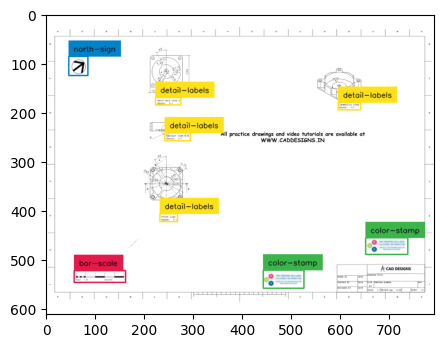

In [16]:
import random
# select random image

image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root,image['file_name'])
print(image_path)
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
print(id2label)
labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (5, 5))

In [17]:
def loadModel(MODEL_PATH, CHECKPOINT):
    model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
    image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
    return model, image_processor

In [19]:
checkpoint = 'facebook/detr-resnet-50'
model_path = 'models/DETR-run7'

model, image_processor = loadModel(model_path, checkpoint)

In [20]:
ground_truth = create_ground_truth_dict('dataset2/test/result.json')


In [22]:
# ground_truth
{
    'images/4fdca17b-drawing_7.png': 
        {
            'boxes': [
                [109.90697674418603,136.0,151.02325581395348,176.32558139534885],
                [542.4186046511628,364.51162790697674,634.9302325581396,407.2093023255814],
                [426.1860465116279,460.9767441860465,535.3023255813954,487.86046511627916],
                [214.27906976744188,517.9069767441861,290.9767441860465,547.1627906976744]
            ],
            'labels': [3, 1, 0, 2]
        },
}

In [117]:
def inference(image_folder, CONFIDENCE_THRESHOLD):
    results = {}
    
    for img in os.listdir(image_folder):
        IMAGE_PATH = os.path.join(image_folder, img)
        print(f"Processing {IMAGE_PATH}")

        image = cv2.imread(IMAGE_PATH)
        inputs = image_processor(images=image, return_tensors='pt')

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Get ground truth for this image
        target = ground_truth.get(img, {'boxes': torch.empty((0, 4)), 'labels': torch.empty((0,), dtype=torch.long)})
        # target = {k: torch.tensor(v).to(model.device) for k, v in target.items()}
        target = {k: v.clone().detach().to(model.device) for k, v in target.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            
            # Post-process
            target_sizes = torch.tensor([image.shape[:2]]).to(model.device)
            result = image_processor.post_process_object_detection(
                outputs=outputs,
                threshold=CONFIDENCE_THRESHOLD,
                target_sizes=target_sizes
            )[0]
        # results.append([IMAGE_PATH.replace('Temp/', ''), result])
        results[IMAGE_PATH.replace('Temp/', '')] = result
            
    return results


In [118]:
results = inference('Temp/images', 0.5)

Processing Temp/images\11913d58-drawing_88.png
Processing Temp/images\17bd5f92-drawing_106.png
Processing Temp/images\2067578c-drawing_24.png
Processing Temp/images\2466f98b-drawing_67.png
Processing Temp/images\3108be30-drawing_43.png
Processing Temp/images\449d473c-drawing_25.png
Processing Temp/images\4fdca17b-drawing_7.png
Processing Temp/images\5acab2e6-drawing_64.png
Processing Temp/images\8318502d-drawing_15.png
Processing Temp/images\92e4c80c-drawing_45.png
Processing Temp/images\a01b4a37-drawing_168.png
Processing Temp/images\a34b8e8d-drawing_44.png
Processing Temp/images\a55f419c-drawing_48.png
Processing Temp/images\af0c0b68-drawing_76.png
Processing Temp/images\b6c7e8be-drawing_56.png
Processing Temp/images\cc5b592c-drawing_113.png
Processing Temp/images\e616d66b-drawing_123.png
Processing Temp/images\eef413ab-drawing_22.png
Processing Temp/images\f601361a-drawing_42.png


In [119]:
results

{'images\\11913d58-drawing_88.png': {'scores': tensor([0.5285, 0.9101, 0.6954, 0.6353, 0.7784, 0.9503]),
  'labels': tensor([1, 3, 2, 2, 3, 2]),
  'boxes': tensor([[278.4949, 528.8150, 360.5984, 558.0323],
          [ 46.7326,  70.2028,  80.9400, 104.4009],
          [216.3189, 518.3107, 292.1606, 546.7127],
          [214.2663, 519.2744, 292.6411, 547.4644],
          [ 39.9978, 352.8757,  75.7294, 385.8117],
          [623.9429, 267.7162, 710.0599, 292.2522]])},
 'images\\17bd5f92-drawing_106.png': {'scores': tensor([0.9489, 0.8784, 0.8229, 0.9387, 0.9544, 0.8222]),
  'labels': tensor([2, 0, 3, 2, 2, 1]),
  'boxes': tensor([[428.5779, 281.2126, 526.5462, 308.8688],
          [ 48.0613, 513.4713, 136.8942, 533.4201],
          [594.3514,  94.2488, 631.0280, 127.8965],
          [425.9916, 109.7946, 497.0291, 136.6798],
          [ 78.7774, 263.3436, 174.2547, 290.3559],
          [616.6947, 385.5923, 695.2281, 415.3440]])},
 'images\\2067578c-drawing_24.png': {'scores': tensor([0.8869

In [120]:
for k in results:
    print(k,' = ', results[k]['labels'].clone().detach().to('cpu').numpy())

images\11913d58-drawing_88.png  =  [1 3 2 2 3 2]
images\17bd5f92-drawing_106.png  =  [2 0 3 2 2 1]
images\2067578c-drawing_24.png  =  [2 3 0 2]
images\2466f98b-drawing_67.png  =  [0 1 2 2 0 0 0 3 2]
images\3108be30-drawing_43.png  =  [1 0 3 2 2]
images\449d473c-drawing_25.png  =  [2 3 0 2 2 1 2 2]
images\4fdca17b-drawing_7.png  =  [1 3 1 2]
images\5acab2e6-drawing_64.png  =  [3 2 0 2 2]
images\8318502d-drawing_15.png  =  [1 0 2 2 3]
images\92e4c80c-drawing_45.png  =  [2 3 1 0 2 2 2]
images\a01b4a37-drawing_168.png  =  [1 2 3 2]
images\a34b8e8d-drawing_44.png  =  [1 0 2 3]
images\a55f419c-drawing_48.png  =  [0 3 1]
images\af0c0b68-drawing_76.png  =  [2 1 2 2 0 3 2 2 2 3 2]
images\b6c7e8be-drawing_56.png  =  [3 1 2 0 0 2]
images\cc5b592c-drawing_113.png  =  [0 3 2 2 2]
images\e616d66b-drawing_123.png  =  [1 3 1 2]
images\eef413ab-drawing_22.png  =  [1 3 2 2 2 1]
images\f601361a-drawing_42.png  =  [0 3 1 2 2 2 1 2]


0 = bar-scale
1 = color-stamp
2 = detail-labels
3 = north-sign

In [77]:
# results
dt = {
  'images\\4fdca17b-drawing_7.png': 
    {'scores': [0.8641, 0.9163, 0.5303, 0.8287],
     'labels': [1, 3, 1, 2],
     'boxes': 
       [
          [547.5405, 369.9310, 631.3417, 401.3426],
          [109.0559, 139.7999, 146.5509, 175.9208],
          [425.1327, 463.6634, 531.3279, 483.3474],
          [216.4242, 516.2832, 289.2458, 543.7466]
       ]
    },
}

# ground_truth
gt = {
    'images/4fdca17b-drawing_7.png': 
        {
            'boxes': [
                [109.90697674418603,136.0,151.02325581395348,176.32558139534885],
                [542.4186046511628,364.51162790697674,634.9302325581396,407.2093023255814],
                [426.1860465116279,460.9767441860465,535.3023255813954,487.86046511627916],
                [214.27906976744188,517.9069767441861,290.9767441860465,547.1627906976744]
            ],
            'labels': [3, 1, 0, 2]
        },
}

In [72]:
import pandas as pd

In [82]:
gt['images/4fdca17b-drawing_7.png']['boxes']

[[109.90697674418603, 136.0, 151.02325581395348, 176.32558139534885],
 [542.4186046511628, 364.51162790697674, 634.9302325581396, 407.2093023255814],
 [426.1860465116279, 460.9767441860465, 535.3023255813954, 487.86046511627916],
 [214.27906976744188, 517.9069767441861, 290.9767441860465, 547.1627906976744]]

In [81]:
gt['images/4fdca17b-drawing_7.png']['labels']

[3, 1, 0, 2]

In [84]:
df = pd.DataFrame(gt['images/4fdca17b-drawing_7.png']['boxes'], columns=['x1', 'y1', 'x2', 'y2'])


In [85]:
df['labels'] = gt['images/4fdca17b-drawing_7.png']['labels']
df

,x1,y1,x2,y2,labels
0,109.906977,136.000000,151.023256,176.325581,3
1,542.418605,364.511628,634.930233,407.209302,1
2,426.186047,460.976744,535.302326,487.860465,0
3,214.279070,517.906977,290.976744,547.162791,2


In [191]:
predictions_df = pd.DataFrame()
for k in results:
    df3 = pd.DataFrame(results[k]['boxes'].detach().to('cpu').numpy(), columns=['x1', 'y1', 'x2', 'y2'])
    df3['labels'] = results[k]['labels'].detach().to('cpu').numpy()
    df3['image'] = k.lstrip('images\\')
    predictions_df = pd.concat([predictions_df, df3], ignore_index=True)
    
predictions_df.shape

(110, 6)

In [136]:
predictions_df.sample(10)

,x1,y1,x2,y2,labels,image
45,225.468124,174.828308,296.145081,200.474487,2,5acab2e6-drawing_64.png
58,615.590210,294.428589,664.007080,308.964447,2,92e4c80c-drawing_45.png
100,188.908524,123.500603,260.361847,148.467377,2,f413ab-drawing_22.png
7,48.061279,513.471252,136.894226,533.420105,0,17bd5f92-drawing_106.png
15,374.496033,426.643036,445.541931,453.625031,2,2067578c-drawing_24.png
96,551.863464,381.363708,635.587708,411.691254,1,f413ab-drawing_22.png
86,669.182312,243.019669,716.589722,259.756866,2,b6c7e8be-drawing_56.png
59,451.566864,515.324524,529.378418,548.450562,1,01b4a37-drawing_168.png
1,46.732620,70.202827,80.939987,104.400940,3,11913d58-drawing_88.png
51,414.187927,70.926659,449.319183,104.993088,3,8318502d-drawing_15.png


In [111]:
label_mapping = {
    'bar-scale': 0,
    'color-stamp': 1,
    'detail-labels': 2,
    'north-sign': 3
}

# ground_truth_df['labels'] = ground_truth_df['labels'].replace(label_mapping)

In [137]:
ground_truth_df

,x1,y1,x2,y2,labels,image
0,109.906977,136.000000,151.023256,176.325581,3,4fdca17b-drawing_7.png
1,542.418605,364.511628,634.930233,407.209302,1,4fdca17b-drawing_7.png
2,426.186047,460.976744,535.302326,487.860465,0,4fdca17b-drawing_7.png
3,214.279070,517.906977,290.976744,547.162791,2,4fdca17b-drawing_7.png
4,411.162791,68.000000,448.325581,105.953488,3,8318502d-drawing_15.png
...,...,...,...,...,...,...
111,513.674419,425.674419,551.534884,467.627907,3,01b4a37-drawing_168.png
112,450.232558,512.651163,534.139535,547.441860,1,01b4a37-drawing_168.png
113,108.465116,526.976744,221.023256,552.558140,0,01b4a37-drawing_168.png
114,104.372093,563.813953,218.976744,584.279070,0,01b4a37-drawing_168.png


In [192]:
ground_truth_df = pd.DataFrame()
for k in ground_truth:
    df3 = pd.DataFrame(ground_truth[k]['boxes'], columns=['x1', 'y1', 'x2', 'y2'])
    df3['labels'] = ground_truth[k]['labels']
    df3['image'] = k.lstrip('images/')
    ground_truth_df = pd.concat([ground_truth_df, df3], ignore_index=True)
    
ground_truth_df.shape

(116, 6)

In [130]:
ground_truth_df

,x1,y1,x2,y2,labels,image
0,109.906977,136.000000,151.023256,176.325581,3,4fdca17b-drawing_7.png
1,542.418605,364.511628,634.930233,407.209302,1,4fdca17b-drawing_7.png
2,426.186047,460.976744,535.302326,487.860465,0,4fdca17b-drawing_7.png
3,214.279070,517.906977,290.976744,547.162791,2,4fdca17b-drawing_7.png
4,411.162791,68.000000,448.325581,105.953488,3,8318502d-drawing_15.png
...,...,...,...,...,...,...
111,513.674419,425.674419,551.534884,467.627907,3,01b4a37-drawing_168.png
112,450.232558,512.651163,534.139535,547.441860,1,01b4a37-drawing_168.png
113,108.465116,526.976744,221.023256,552.558140,0,01b4a37-drawing_168.png
114,104.372093,563.813953,218.976744,584.279070,0,01b4a37-drawing_168.png


In [112]:
ground_truth_df['labels'] = ground_truth_df['labels'].replace(label_mapping)

C:\Users\Chirantan_Degloorkar\AppData\Local\Temp\ipykernel_16544\2224024633.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ground_truth_df['labels'] = ground_truth_df['labels'].replace(label_mapping)


In [115]:
ground_truth_df['labels'].value_counts()

labels
2    50
0    27
3    22
1    17
Name: count, dtype: int64

In [122]:
predictions_df['labels'].value_counts()

labels
2    51
3    21
1    20
0    18
Name: count, dtype: int64

In [193]:
ground_truth_df = ground_truth_df.sort_values(by=['image', 'labels'])

In [194]:
predictions_df = predictions_df.sort_values(by=['image', 'labels'])

In [154]:
# ground_truth_df.loc[ground_truth_df['image'] == '4fdca17b-drawing_7.png']

image_list = ground_truth_df['image'].unique()
image_list

array(['01b4a37-drawing_168.png', '11913d58-drawing_88.png',
       '17bd5f92-drawing_106.png', '2067578c-drawing_24.png',
       '2466f98b-drawing_67.png', '3108be30-drawing_43.png',
       '34b8e8d-drawing_44.png', '449d473c-drawing_25.png',
       '4fdca17b-drawing_7.png', '55f419c-drawing_48.png',
       '5acab2e6-drawing_64.png', '616d66b-drawing_123.png',
       '8318502d-drawing_15.png', '92e4c80c-drawing_45.png',
       'b6c7e8be-drawing_56.png', 'cc5b592c-drawing_113.png',
       'f0c0b68-drawing_76.png', 'f413ab-drawing_22.png',
       'f601361a-drawing_42.png'], dtype=object)

In [169]:
ground_truth_df.head(6)

,x1,y1,x2,y2,labels,image
113,108.465116,526.976744,221.023256,552.558140,0,01b4a37-drawing_168.png
114,104.372093,563.813953,218.976744,584.279070,0,01b4a37-drawing_168.png
112,450.232558,512.651163,534.139535,547.441860,1,01b4a37-drawing_168.png
115,386.790698,431.813953,461.488372,456.372093,2,01b4a37-drawing_168.png
110,121.767442,64.465116,159.627907,107.441860,3,01b4a37-drawing_168.png
111,513.674419,425.674419,551.534884,467.627907,3,01b4a37-drawing_168.png


In [170]:
predictions_df.head(6)

,x1,y1,x2,y2,labels,image
59,451.566864,515.324524,529.378418,548.450562,1,01b4a37-drawing_168.png
60,386.744873,433.619385,455.876526,460.668854,2,01b4a37-drawing_168.png
62,111.380508,558.815979,209.870453,582.063782,2,01b4a37-drawing_168.png
61,121.154549,69.866692,154.308807,107.767235,3,01b4a37-drawing_168.png
0,278.494934,528.815002,360.598358,558.032288,1,11913d58-drawing_88.png
2,216.318863,518.310669,292.160645,546.712708,2,11913d58-drawing_88.png


In [172]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    - box1: (x1, y1, x2, y2) coordinates of the first bounding box
    - box2: (x1, y1, x2, y2) coordinates of the second bounding box
    
    Returns:
    - iou: Intersection over Union (IoU) value
    """
    
    # Unpack the coordinates of the two boxes
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate the (x, y) coordinates of the intersection rectangle
    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)
    
    # Calculate the area of the intersection rectangle
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # Calculate the area of both bounding boxes
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    # Calculate the union area
    union_area = box1_area + box2_area - inter_area
    
    # Calculate the IoU
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

# Example usage
actual_box = (450.232558, 512.651163, 534.139535, 547.441860)
predicted_box = (451.566864, 515.324524, 529.378418, 548.450562)
iou = calculate_iou(actual_box, predicted_box)
print(f'IoU: {iou}')

IoU: 0.8336805212871887


In [173]:
import pandas as pd

# Predicted DataFrame
predicted_data = [
    [451.566864, 515.324524, 529.378418, 548.450562, 1, '01b4a37-drawing_168.png'],
    [386.744873, 433.619385, 455.876526, 460.668854, 2, '01b4a37-drawing_168.png'],
    [111.380508, 558.815979, 209.870453, 582.063782, 2, '01b4a37-drawing_168.png'],
    [121.154549, 69.866692, 154.308807, 107.767235, 3, '01b4a37-drawing_168.png']
]
predicted_columns = ['x1', 'y1', 'x2', 'y2', 'label', 'image']
predicted_df = pd.DataFrame(predicted_data, columns=predicted_columns)

# Ground Truth DataFrame
ground_truth_data = [
    [108.465116, 526.976744, 221.023256, 552.558140, 0, '01b4a37-drawing_168.png'],
    [104.372093, 563.813953, 218.976744, 584.279070, 0, '01b4a37-drawing_168.png'],
    [450.232558, 512.651163, 534.139535, 547.441860, 1, '01b4a37-drawing_168.png'],
    [386.790698, 431.813953, 461.488372, 456.372093, 2, '01b4a37-drawing_168.png'],
    [121.767442, 64.465116, 159.627907, 107.441860, 3, '01b4a37-drawing_168.png'],
    [513.674419, 425.674419, 551.534884, 467.627907, 3, '01b4a37-drawing_168.png']
]
ground_truth_columns = ['x1', 'y1', 'x2', 'y2', 'label', 'image']
ground_truth_df = pd.DataFrame(ground_truth_data, columns=ground_truth_columns)


In [198]:
predicted_df = predicted_df.rename(columns={'label': 'labels'})

In [292]:
ground_truth_df['row_count'] = ground_truth_df.groupby(['image', 'labels']).cumcount() + 1
predictions_df['row_count'] = predictions_df.groupby(['image', 'labels']).cumcount() + 1

In [294]:
# ground_truth_df.tail(20)

In [295]:
# predicted_df.shape, ground_truth_df

In [296]:
merged_df = pd.merge(ground_truth_df, predictions_df, on=['image', 'labels', 'row_count'], how='outer', suffixes=('_gt', '_pred'), validate='many_to_many')

In [297]:
merged_df['iou'] = merged_df.apply(lambda x: calculate_iou((x['x1_gt'], x['y1_gt'], x['x2_gt'], x['y2_gt']), (x['x1_pred'], x['y1_pred'], x['x2_pred'], x['y2_pred'])), axis=1)

In [299]:
merged_df.sample(10)

,x1_gt,y1_gt,x2_gt,y2_gt,labels,image,row_count,x1_pred,y1_pred,x2_pred,y2_pred,iou
47,231.674419,422.232558,265.674419,438.046512,2,449d473c-drawing_25.png,2,282.929626,281.855988,318.131744,290.994598,0.000000
75,219.813953,143.906977,290.186047,162.093023,2,8318502d-drawing_15.png,2,218.382019,145.058838,289.046753,165.038559,0.779808
95,45.860465,520.279070,150.232558,544.000000,0,f0c0b68-drawing_76.png,1,46.317429,518.683838,151.633362,539.919617,0.764023
49,472.837209,188.976744,507.627907,205.581395,2,449d473c-drawing_25.png,4,469.272675,192.272537,506.521362,208.916840,0.598234
113,57.720930,523.441860,162.883721,547.162791,0,f601361a-drawing_42.png,1,58.494934,523.148376,164.045700,545.756104,0.912949
68,NaN,NaN,NaN,NaN,1,616d66b-drawing_123.png,2,260.107483,527.338074,345.720642,557.048279,NaN
117,242.744186,242.744186,294.139535,258.558140,2,f601361a-drawing_42.png,2,242.537521,244.552567,294.235382,260.279938,0.794493
31,410.372093,73.534884,462.558140,90.930233,2,2466f98b-drawing_67.png,2,213.067307,284.388763,264.451935,301.638733,0.000000
59,63.255814,68.000000,106.744186,106.744186,3,55f419c-drawing_48.png,1,65.452705,70.357384,100.210007,104.276123,0.699691
23,374.000000,427.767442,445.953488,455.441860,2,2067578c-drawing_24.png,2,374.496033,426.643036,445.541931,453.625031,0.886981


In [300]:
merged_df.loc[merged_df['image'] == '4fdca17b-drawing_7.png']

,x1_gt,y1_gt,x2_gt,y2_gt,labels,image,row_count,x1_pred,y1_pred,x2_pred,y2_pred,iou
52,426.186047,460.976744,535.302326,487.860465,0,4fdca17b-drawing_7.png,1,NaN,NaN,NaN,NaN,NaN
53,542.418605,364.511628,634.930233,407.209302,1,4fdca17b-drawing_7.png,1,547.540527,369.930969,631.341736,401.342590,0.666408
54,NaN,NaN,NaN,NaN,1,4fdca17b-drawing_7.png,2,425.132690,463.663361,531.327881,483.347412,NaN
55,214.279070,517.906977,290.976744,547.162791,2,4fdca17b-drawing_7.png,1,216.424210,516.283203,289.245819,543.746582,0.796614
56,109.906977,136.000000,151.023256,176.325581,3,4fdca17b-drawing_7.png,1,109.055870,139.799896,146.550949,175.920761,0.783768


In [310]:
TP, FP, FN = 0, 0, 0
merged_df['result'] = ''
for i in range(merged_df.shape[0]):
    # if merged_df['image'][i] == '4fdca17b-drawing_7.png':
    if merged_df['iou'][i] > 0.6:
        print('True Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        TP += 1
        # df.loc[row_indexer, "col"] = values
        merged_df.loc[i, 'result'] = 'TP'
        # merged_df['result'][i] = 'TP'
    elif merged_df['iou'][i] == 0:
        print('False Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        FP += 1
        merged_df.loc[i, 'result'] = 'FP'
    elif pd.isna(merged_df['iou'][i]):
        if pd.isna(merged_df['x1_pred'][i]):
            print('False Negative')
            FN += 1
            merged_df.loc[i, 'result'] = 'FN'
        elif pd.isna(merged_df['x1_gt'][i]):
            print('False Positive')
            FP += 1
            merged_df.loc[i, 'result'] = 'FP'
    else: 
        print('False Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        FP += 1
        merged_df.loc[i, 'result'] = 'FP'
        # merged_df['result'][i] = 'FP'

False Negative
False Negative
True Positive
IoU 2: 0.8337
True Positive
IoU 3: 0.7371
False Positive
True Positive
IoU 5: 0.7362
False Negative
False Negative
True Positive
IoU 8: 0.8958
True Positive
IoU 9: 0.6705
False Positive
IoU 10: 0.0000
False Positive
False Positive
IoU 12: 0.0000
False Positive
IoU 13: 0.0000
True Positive
IoU 14: 0.8068
True Positive
IoU 15: 0.8236
False Positive
IoU 16: 0.0000
False Positive
IoU 17: 0.0000
False Positive
IoU 18: 0.0000
True Positive
IoU 19: 0.8350
True Positive
IoU 20: 0.7581
False Negative
True Positive
IoU 22: 0.8376
True Positive
IoU 23: 0.8870
True Positive
IoU 24: 0.7583
True Positive
IoU 25: 0.7853
False Positive
IoU 26: 0.0000
False Positive
IoU 27: 0.0000
False Positive
IoU 28: 0.0000
True Positive
IoU 29: 0.6801
False Positive
IoU 30: 0.0000
False Positive
IoU 31: 0.0000
True Positive
IoU 32: 0.6815
True Positive
IoU 33: 0.7552
True Positive
IoU 34: 0.7710
True Positive
IoU 35: 0.8548
False Positive
IoU 36: 0.0000
False Positive
IoU

In [311]:
# print(TP, FP, FN)
print("True Positive - ", TP)
print("False Positive - ", FP)
print("False Negative - ", FN)

True Positive -  71
False Positive -  39
False Negative -  11


In [303]:
print("Accuracy - ", TP/(TP+FP+FN))

Accuracy -  0.5867768595041323


In [304]:
print("Precision - ", TP/(TP+FP))

Precision -  0.6761904761904762


In [305]:
print("Recall - ", TP/(TP+FN))

Recall -  0.8160919540229885
